<a href="https://colab.research.google.com/github/franmazzaro/7506R-2C2023-GRUPO39/blob/main/7506R_TP1_GRUPO39_CHP4_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.preprocessing import StandardScaler


import tensorflow as tf
from tensorflow import keras
# from keras.utils.vis_utils import plot_model
# import visualkeras

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
# Importamos el dataset que trabajamos en el checkpoint 2 con las varibles categóricas como dummies
reservas = pd.read_csv('/content/sample_data/reservas_dummies.csv')

# Importamos el dataset de test con las variables categóricas como dummies
test = pd.read_csv('/content/sample_data/test_dummies.csv')

In [4]:
# Droppeamos el id para poder entrenar y predecir
ids_train = reservas["id"]
ids_test = test["id"]
reservas.drop(columns="id", inplace=True)
test.drop(columns="id", inplace=True)

# Ordenamos las columnas
reservas = reservas.reindex(sorted(reservas.columns), axis=1)
test = test.reindex(sorted(test.columns), axis=1)

# Imputamos datos faltantes
test['agent'] = test['agent'].fillna(-1)
test['company'] = test['company'].fillna(-1)

In [5]:
def mostrar_metricas(y_test, y_pred):
  #Cantidad de aciertos
  print('correctas: ', np.sum(y_test == y_pred))
  print('total: ', len(y_test))

  print(classification_report(y_test, y_pred))

  #Grafico la matriz de confusión
  tabla=confusion_matrix(y_test, y_pred)
  sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [6]:
def exportar_prediccion(ids_test, y_pred, filename):
  prediccion = pd.DataFrame({"id": ids_test, "is_canceled": y_pred})
  prediccion.to_csv('/content/sample_data/prediccion_'+filename+'.csv', index = False)

In [7]:
a = reservas.drop(['is_canceled'], axis=1)
b = reservas['is_canceled']

In [8]:
# Normalización Min-Max en los datos de entrenamiento
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(a)

# Balanceo de clases
class_0 = X_train_normalized[b == 0]
class_1 = X_train_normalized[b == 1]

# Balanceo de clases (sobremuestreo de la clase minoritaria)

# Selecciona los ejemplos de la clase mayoritaria (clase "0")
class_0 = X_train_normalized[b == 0]

# Selecciona los ejemplos de la clase minoritaria (clase "1")
class_1 = X_train_normalized[b == 1]

# Realiza sobremuestreo de la clase minoritaria (clase "1")
# - replace=True: Permite muestrear con reemplazo
# - n_samples=len(class_0): Genera tantas muestras de la clase "1" como ejemplos de la clase "0"
class_0_oversampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)

# Combina los datos equilibrados en X_train_balanced y y_train_balanced
# - np.vstack: Apila verticalmente los arrays
# - np.hstack: Concatena horizontalmente los arrays
X_train_balanced = np.vstack((class_0, class_0_oversampled))
y_train_balanced = np.hstack((b[b == 0], np.ones(len(class_0))))

In [9]:
# Datos con normalización y balanceo
x_train_bal, x_test_bal, y_train_bal, y_test_bal = train_test_split(X_train_balanced, y_train_balanced, test_size=0.20, random_state=0)
print(y_test_bal)

test_bal  = scaler.transform(test)

[1. 1. 1. ... 0. 0. 0.]


In [45]:
cant_clases=len(np.unique(y_train_bal))
print(cant_clases)
d_in=len(a.columns)
print(d_in)
modelo_1 = keras.Sequential([
    keras.layers.Dense(1,input_shape=(d_in,), activation='sigmoid'),
    keras.layers.Dense(213, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')])

modelo_1.summary()

2
213
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1)                 214       
                                                                 
 dense_18 (Dense)            (None, 213)               426       
                                                                 
 dropout_2 (Dropout)         (None, 213)               0         
                                                                 
 dense_19 (Dense)            (None, 1)                 214       
                                                                 
Total params: 854 (3.34 KB)
Trainable params: 854 (3.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
modelo_1.compile(
  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
  loss='binary_crossentropy',
  # metricas para ir calculando en cada iteracion o batch
  metrics=['AUC'],
)

cant_epochs=100
modelo_titanic1_historia = modelo_1.fit(x_train_bal,y_train_bal,
                                                epochs=cant_epochs,
                                                batch_size=50,verbose=False)

369/369 [==============================] - 1s 2ms/step
[[0.5470773 ]
 [0.05758994]
 [0.9882712 ]
 ...
 [0.17248832]
 [0.3948635 ]
 [0.05923622]]


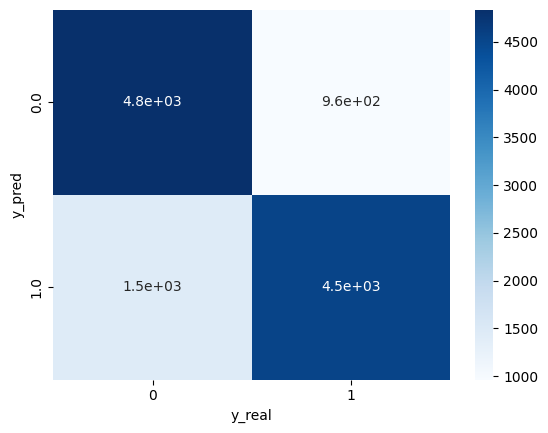

In [48]:
y_predic_porcentaje = modelo_1.predict(x_test_bal)
#median_prediccion = y_predic_porcentaje.median
print(y_predic_porcentaje)
y_predic_cat = np.where(y_predic_porcentaje>0.494,1,0)

ds_validacion=pd.DataFrame(y_predic_cat,y_test_bal).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

369/369 [==============================] - 1s 3ms/step
correctas:  69645446
total:  11794
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5411
           1       0.83      0.78      0.81      6383

    accuracy                           0.80     11794
   macro avg       0.80      0.80      0.80     11794
weighted avg       0.80      0.80      0.80     11794



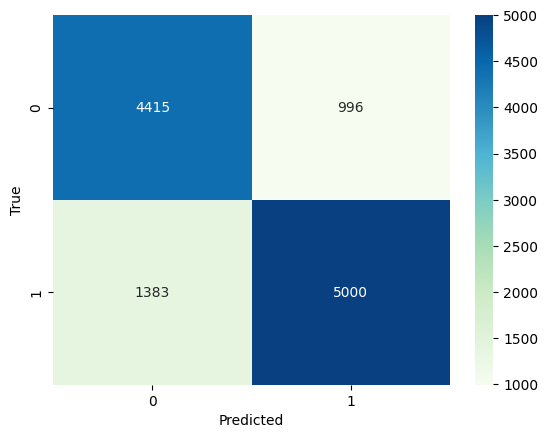

In [53]:
y_predic_ej1 = modelo_1.predict(x_test_bal)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.4,1,0)
mostrar_metricas(y_predic_cat_ej1, y_test_bal)

369/369 [==============================] - 1s 3ms/step
correctas:  69004520
total:  11794
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      8648
           1       0.49      0.94      0.65      3146

    accuracy                           0.73     11794
   macro avg       0.73      0.79      0.71     11794
weighted avg       0.84      0.73      0.74     11794



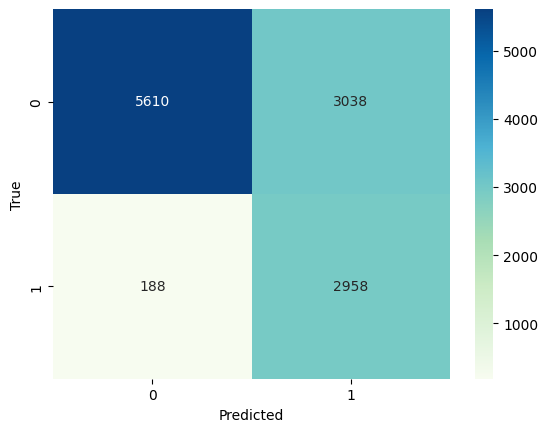

In [55]:
y_predic_ej1 = modelo_1.predict(x_test_bal)
y_predic_cat_ej1 = np.where(y_predic_ej1>0.78,1,0)
mostrar_metricas(y_predic_cat_ej1, y_test_bal)

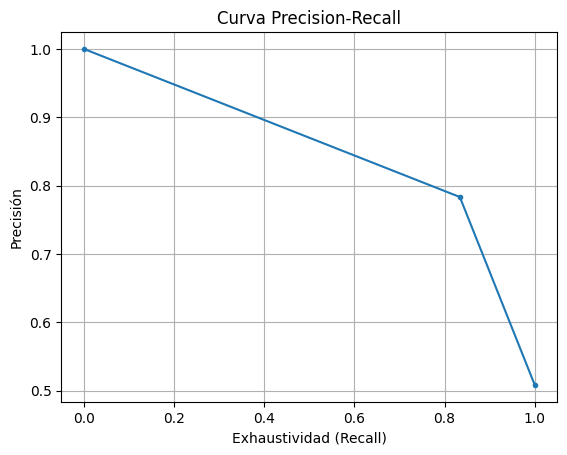

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, thresholds = precision_recall_curve(y_test_bal, y_predic_cat_ej1)


plt.plot(recall, precision, marker='.')
plt.xlabel('Exhaustividad (Recall)')
plt.ylabel('Precisión')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.show()

In [25]:
y_pred_ = modelo_1.predict(test_bal)
y_pred = np.where(y_pred_ > 0.5, 1, 0).astype(int)

830/830 [==============================] - 2s 2ms/step


In [26]:
y_pred = y_pred.reshape(-1)

In [27]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
exportar_prediccion(ids_test, y_pred, "redes_neuronales_1")

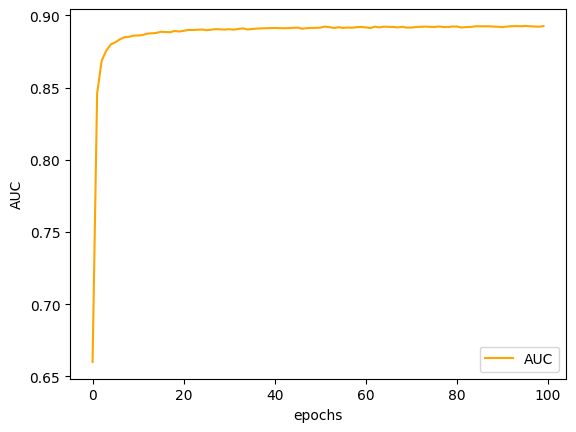

In [57]:
epochs = range(cant_epochs)

plt.plot(epochs, modelo_titanic1_historia.history['auc'], color='orange', label='AUC')
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.legend()

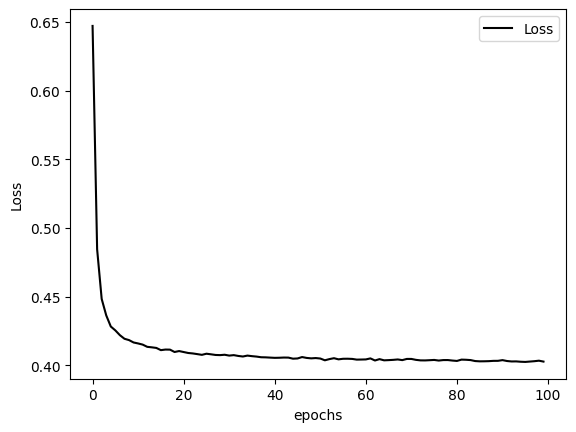

In [58]:
epochs = range(cant_epochs)

plt.plot(epochs, modelo_titanic1_historia.history['loss'], color='black', label='Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()